Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

## Assignment


### Importing

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split


###  Wrangling


In [4]:

def wrangle(x):
    x = x.copy() #to avoid warning
    
    x['latittude'] = x['latitude'].replace(-2e-09,0) #to replace near 0 with 0
    
    cols_with_zero = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    
    for col in cols_with_zero: #Replace zeroes in cols above with NaN
        x[col] = x[col].replace(0, np.nan)
        x[col+'_MISSING'] = x[col].isnull() #adding a missing indicator
    
    duplicates = ['extraction_type_class', 'extraction_type_group', 'quantity_group', 'payment', 'source', 'waterpoint_type_group']
    x = x.drop(columns=duplicates)

    x = x.drop(columns=['id','recorded_by']) # Unusable info

    x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True) #convert to DateTime
    # Extract components from date_recorded, then drop the original column
    x['year_recorded'] = x['date_recorded'].dt.year
    x['month_recorded'] = x['date_recorded'].dt.month
    x['day_recorded'] = x['date_recorded'].dt.day
    x = x.drop(columns='date_recorded')

    x['years'] = x['year_recorded'] - x['construction_year']
    x['years_MISSING'] = x['years'].isnull()

    return x

train = wrangle(train)
test = wrangle(test)

target = 'status_group'

X_train = train.drop(columns=target)

y_train = train[target]

## RandoomizedCV 

In [5]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

params = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score= True,
    n_jobs=-1
)
search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  5.7min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  6.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  6.9min remaining:   45.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.6min finished


In [6]:
print('Best hyperparameters', search.best_params_)
print('Score:', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.2025084450136595, 'randomforestclassifier__n_estimators': 495, 'simpleimputer__strategy': 'mean'}
Score: 0.8081144781144781


In [7]:
y_pred = search.predict(test)

## Confusion matrix

### Model for confusion matrix

In [18]:
train2 = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

In [19]:
train2, val = train_test_split(train2, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [20]:
train2 = wrangle(train2)
val = wrangle(val)



In [21]:
target = 'status_group'
X_train2 = train2.drop(columns=target)
y_train2 = train2[target]
X_val = val.drop(columns=target)
y_val = val[target]

In [24]:
search2 = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score= True,
    n_jobs=-1
)
search2.fit(X_train2, y_train2);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  3.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  4.7min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  5.4min remaining:   35.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.7min finished


In [25]:
print('Best hyperparameters', search2.best_params_)
print('Score:', search2.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.315943983171484, 'randomforestclassifier__n_estimators': 233, 'simpleimputer__strategy': 'median'}
Score: 0.7992762310732205


In [26]:
y_pred2 = search2.predict(X_val)

In [37]:
y_pred2_sub = search.predict(test)

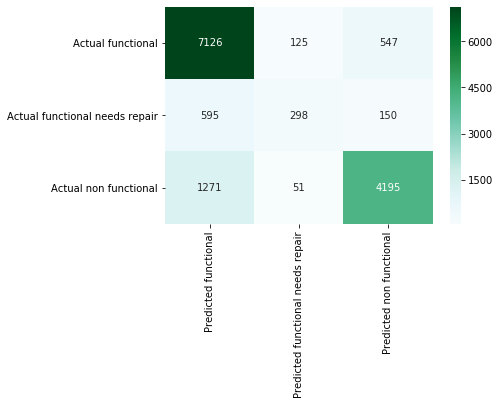

In [30]:
def plot_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                        columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='BuGn')
plot_matrix(y_val,y_pred2);

In [31]:
search1 = sample_submission.copy()

In [32]:
search1['status_group'] = y_pred

In [33]:
search2 = sample_submission.copy()

In [38]:
search2['status_group'] = y_pred2_sub

In [35]:
search1.to_csv('search1.csv', index=False)

In [39]:
search2.to_csv('search2.csv', index=False)

## Stacking submissions

In [40]:
pwd

'C:\\Users\\Hakuj\\Documents\\GitHub\\DS-Unit-2-Kaggle-Challenge\\module4'

In [42]:
files = ['big_model_sub.csv', 'Dtree_Sub.csv', 'Dtree_sub2.csv', 'my-ultimate-ensemble-submission.csv',
        'RandCV1.csv', 'random_forest_1.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = sample_submission
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-second-ultimate-ensemble-submission.csv', index=False)